# Qubits having different failure probability, following a distribution


Compare: qubit loss. Erasure has larger threshold, does that mean we expect that we could get better logical error rates with a distribution, as long as it is "heralded" in the sense that we *know* the relative qubit probabilities? (Also compare: how do we do if we *don't* know them, and the decoder just has the average edge weight? Same as all qubits having the same?)

We could perhaps call this "quality heralding"? 

When it comes to type of distribution to consider, heavy tailed distributions would be the most interesting to consider, as they are probably more realistic to actually model noise in e.g. superconducting qubits. 

In the below, taking a normal distribution we see that if the decoder knows the quality of each qubit, the results improve -- and the larger the standard deviation, the better the performance. Meanwhile if the decoder isn't given this information, the performance is the same as if all had the same probability. (In each case we plot against the mean failure probability.)

In [184]:
from PyMatching import *
import pymatching
import time as time
from scipy.stats import lognorm, norm

In [145]:

L = 4
H = toric_code_x_stabilisers(L)
p = 0.1

#Setting separate qubit probabilities, unformly between 0 and 0.2 for now
qubit_probabilities = (np.random.random(H.shape[1])*2*p)
print('Qubit probabilities:')
print(qubit_probabilities)
print('Mean probability:',np.mean(qubit_probabilities))


#Sanity check of average qubit noise
noise_sum = (np.array([0 for p in qubit_probabilities])).astype(np.uint32)
num_shots = 100000
for i in range(num_shots):
    noise = (np.array([np.random.random() < p for p in qubit_probabilities])).astype(np.uint32)
    noise_sum += noise
print('Average qubit probabilities:')
print(noise_sum/num_shots)

Qubit probabilities:
[0.12642104 0.10995488 0.0330077  0.14727869 0.01905263 0.02960407
 0.18972418 0.01046871 0.13576791 0.05718472 0.07567508 0.18074476
 0.09403787 0.00261178 0.06963499 0.03987755 0.03056213 0.01437695
 0.11153017 0.02665875 0.12820206 0.10002036 0.07112068 0.05709057
 0.0151555  0.19413502 0.04025486 0.10398617 0.15610406 0.12663429
 0.11077663 0.18298826]
Mean probability: 0.0872075945886851
Average qubit probabilities:
[0.12816 0.10961 0.03236 0.14594 0.01952 0.0295  0.19083 0.0108  0.13743
 0.0577  0.07465 0.18034 0.09475 0.00274 0.07001 0.03999 0.03031 0.01448
 0.11257 0.02696 0.12915 0.09953 0.07247 0.0563  0.01468 0.19543 0.04054
 0.10378 0.1558  0.12681 0.1095  0.18435]


In [5]:
# Will be renamed and moved into .py
def num_decoding_failures_vectorised(H, logicals, qubit_probabilities, num_shots):
    matching = Matching.from_check_matrix(H, weights=[np.log((1-p)/p) for p in qubit_probabilities], faults_matrix=logicals)
    noise = (np.array([[np.random.random() < p for p in qubit_probabilities] for shot in range(num_shots)])).astype(np.uint8)
    shots = (noise @ H.T) % 2    
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [142]:
time0 = time.time()
num_shots = 2000
num_realizations = 1000
Ls = [4,6,8]
ps = np.linspace(0.01, 0.13, 13)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    
    for error_probability in ps:
        num_errors = 0
        for error_realization in range(num_realizations):
            qubit_probabilities = (np.random.random(Hx.shape[1])*2*error_probability)
            num_errors += num_decoding_failures_vectorised(Hx, logX, qubit_probabilities, num_shots)
        log_errors.append(num_errors/num_shots/num_realizations)
    log_errors_all_L.append(np.array(log_errors))

print(time.time()-time0)

Simulating L=4...
Simulating L=6...
Simulating L=8...
425.40784335136414


In [143]:
#For comparison

time0 = time.time()
num_shots_same_p = 1000000
log_errors_all_L_same_p = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    
    for error_probability in ps:
        num_errors = 0
        
        qubit_probabilities = np.array([error_probability for i in range(Hx.shape[1])])
            
        num_errors += num_decoding_failures_vectorised(Hx, logX, qubit_probabilities, num_shots_same_p)
        log_errors.append(num_errors/num_shots_same_p)
        
    log_errors_all_L_same_p.append(np.array(log_errors))
    
print(time.time()-time0)

Simulating L=4...
Simulating L=6...
Simulating L=8...
260.2297947406769


[0.89, 0.89, 0.89]


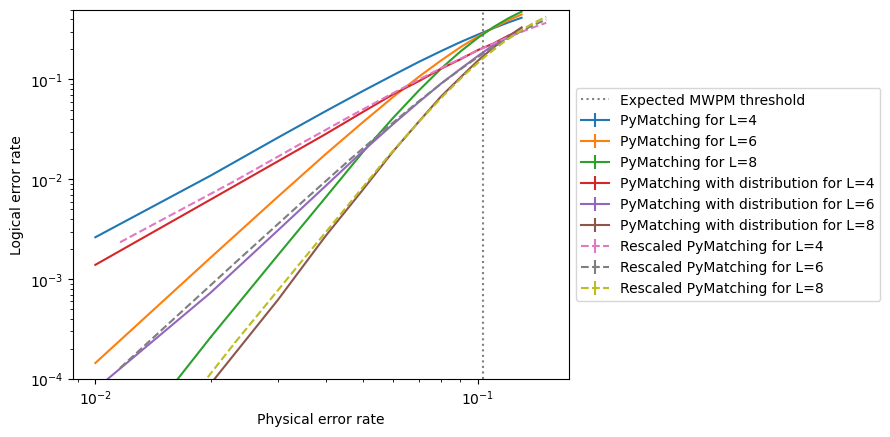

In [183]:
plt.figure()

for L, logical_errors in zip(Ls, log_errors_all_L_same_p):
    std_err = (logical_errors*(1-logical_errors)/num_shots/num_realizations)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))

for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots/num_realizations)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching with distribution for L={}".format(L))

    
# Can we just rescale p_phys and p_log the same for all sizes?
# That should hold at low p if we can still assume the general low probability
# relation of p_log \propto (p/p_thresh)^{(d+1)/2}, which seems to hold
rescalings = [0.89,0.89,0.89]
print(rescalings)

physical_rescaling = 1.16


for L, rescaling, logical_errors in zip(Ls, rescalings, log_errors_all_L_same_p):
    std_err = (logical_errors*(1-logical_errors)/num_shots/num_realizations)**0.5
    plt.errorbar(ps*physical_rescaling, logical_errors*rescaling, yerr=std_err, linestyle="dashed", label="Rescaled PyMatching for L={}".format(L))

    
plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

plt.ylim(bottom=1e-4, top=None)

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Some checks of measures of distributions

Should rather do it by looping over realizations of qubit noise, and checking probability of two physical errors. 

In [ ]:
#need recursive def for multiplying each other
def recursive_products_k(probabilities,k):
    if k == 1:
        return probabilities
    else:
        lower_p = recursive_products_k(probabilities,k-1)
        
        #exclude the probability itself from the list for each product
        #should double check that this actually works out correctly combinatorially...
        return np.array([np.array((list(lower_p[:i]) + list(lower_p[i+1:])))*p for i,p in enumerate(probabilities)]).flatten()

def moment_k(probabilities, k):
    return np.sum(probabilities**k)/len(probabilities)


def different_qubit_products_k(probabilities, k):
    products = recursive_products_k(probabilities,k)
    return np.sum(products)/len(products)

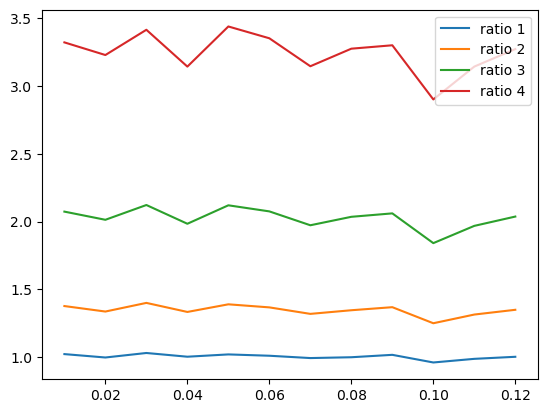

1.00545037223638 1.3470851278880678 2.025321815634921 3.2429389549642664


In [132]:
ratio_1 = []
ratio_2 = []
ratio_3 = []
ratio_4 = []

p_range = np.linspace(0.01, 0.12, 12)
for p in p_range :
    qubit_probabilities = (np.random.random(2000)*2*p)
    res = moment_k(qubit_probabilities,1) / p
    ratio_1.append(res)
    res = moment_k(qubit_probabilities,2) / p**2
    ratio_2.append(res)
    res = moment_k(qubit_probabilities,3) / p**3
    ratio_3.append(res)
    res = moment_k(qubit_probabilities,4) / p**4
    ratio_4.append(res)
    
plt.figure()
plt.plot(p_range, ratio_1, label="ratio 1")
plt.plot(p_range, ratio_2, label="ratio 2")
plt.plot(p_range, ratio_3, label="ratio 3")
plt.plot(p_range, ratio_4, label="ratio 4")

plt.legend()
plt.show()

print(np.mean(ratio_1),np.mean(ratio_2),np.mean(ratio_3),np.mean(ratio_4))

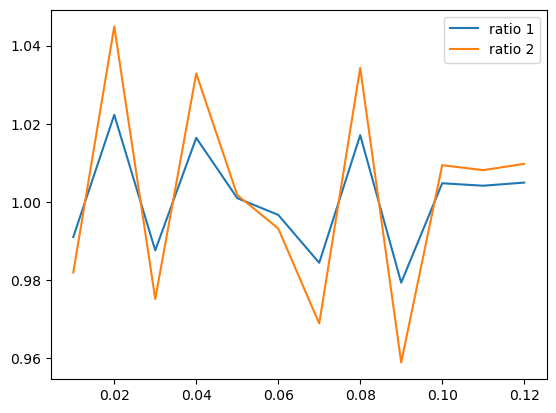

In [61]:
ratio_1 = []
ratio_2 = []

p_range = np.linspace(0.01, 0.12, 12)
for p in p_range :
    qubit_probabilities = (np.random.random(2000)*2*p)
    res = different_qubit_products_k(qubit_probabilities,1) / p
    ratio_1.append(res)
    res = different_qubit_products_k(qubit_probabilities,2) / p**2
    ratio_2.append(res)
plt.figure()
plt.plot(p_range, ratio_1, label="ratio 1")
plt.plot(p_range, ratio_2, label="ratio 2")
plt.legend()
plt.show()

In [103]:
#Checking how often we need to impose cutoffs
p = 0.12
probabilities = lognorm.rvs(s=1.5, scale=p, size=samplesize)
probabilities = [np.min([prob,1]) for prob in probabilities]
print(np.sum([prob == 1 for prob in probabilities])/samplesize)

0.08


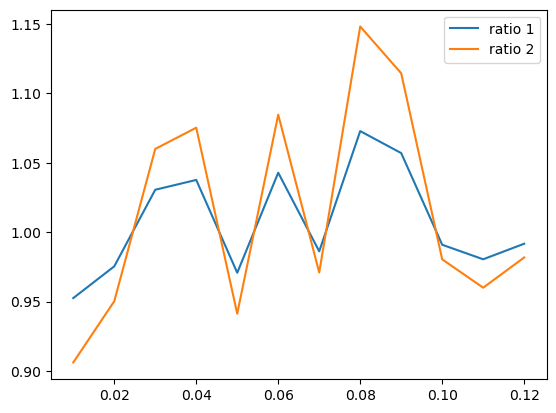

In [104]:
p_range = np.linspace(0.01, 0.12, 12)

ratio_1 = []
ratio_2 = []

for p in p_range :
    
    samplesize = 5000
    
    s_val = 1.5 #larger value makes variance larger
    
    qubit_probabilities = lognorm.rvs(s=s_val, scale=p, size=samplesize)
    
    #qubit_probabilities = [np.min([prob,1]) for prob in qubit_probabilities]
    
    mean = lognorm.stats(s=s_val, scale=p, moments='m') #cutoff will change it away from mean
    #mean = np.sum(qubit_probabilities)/samplesize
    
    res = different_qubit_products_k(qubit_probabilities,1) / mean
    ratio_1.append(res)
    
    res = different_qubit_products_k(qubit_probabilities,2) / mean**2
    ratio_2.append(res)
    
plt.figure()
plt.plot(p_range, ratio_1, label="ratio 1")
plt.plot(p_range, ratio_2, label="ratio 2")
plt.legend()
plt.show()

# Checking if "quality heralding" helps more the larger the variance is

Checking with a normal distribution first for simlicity. loc sets mean, scale sets standard deviation


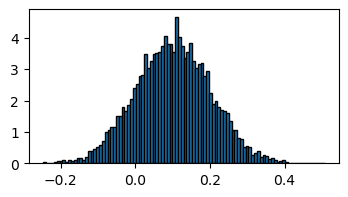

Theoretical mean: 0.1 . Mean of data points before cutoff: 0.10069116666482093
Theoretical variance: 0.010000000000000002


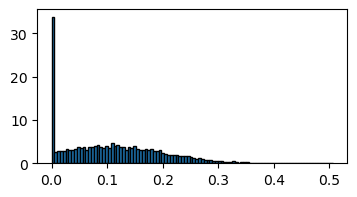

Theoretical mean: 0.1 . Mean of data points after cutoff: 0.1090346851745371


In [193]:
# Generating probabilities

samplesize = 10000
probabilities = norm.rvs(loc = 0.1, scale=0.1, size=samplesize)
mean, var = norm.stats(loc = 0.1, scale = 0.1, moments='mv')

plt.figure(figsize=(4,2))
plt.hist(probabilities, density=True, edgecolor='black', bins=100)
plt.show()

print('Theoretical mean:', mean, '. Mean of data points before cutoff:', np.sum(probabilities)/samplesize)
print('Theoretical variance:', var)

# We can only accept probabilities that lie between 0 and 1. We therefore need to impose a cutoff.
# (Note: the histogram will look slightly different due to having the same number of bins.)
probabilities = [np.max([0,np.min([p,1])]) for p in probabilities]
plt.figure(figsize=(4,2))
plt.hist(probabilities, density=True, edgecolor='black', bins=100)
plt.show()
print('Theoretical mean:', mean, '. Mean of data points after cutoff:', np.sum(probabilities)/samplesize)

std_dev 0
Simulating L=4...
Simulating L=6...
std_dev 0.02
Simulating L=4...
Simulating L=6...
std_dev 0.04
Simulating L=4...
Simulating L=6...
std_dev 0.06
Simulating L=4...
Simulating L=6...


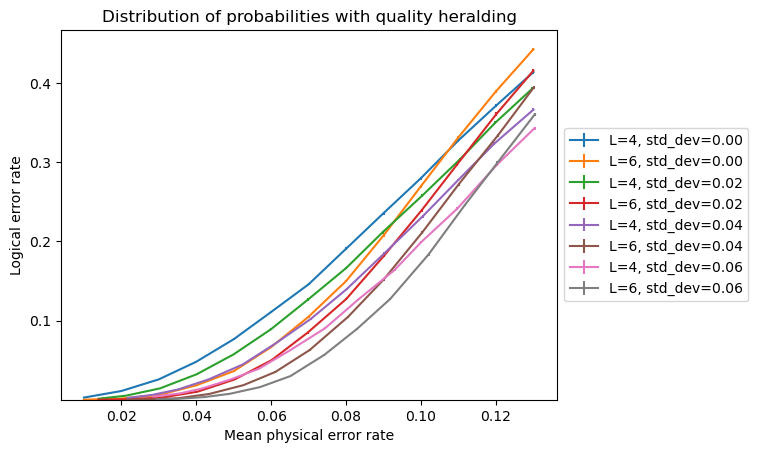

In [219]:


plt.figure()

for std_dev in [0,0.02,0.04,0.06]:
    print("std_dev", std_dev)


    time0 = time.time()
    num_shots = 300
    num_realizations = 200
    Ls = [4,6]
    log_errors_all_L_normal = []

    mean_all_L_normal = []

    for L in Ls:
        print("Simulating L={}...".format(L))
        Hx = toric_code_x_stabilisers(L)
        logX = toric_code_x_logicals(L)
        log_errors = []
        mean_p = []
        for error_probability in ps:
            #print("Error probability",p)
            num_errors = 0
            mean_val = 0
            for error_realization in range(num_realizations):

                qubit_probabilities = norm.rvs(loc = error_probability, scale=std_dev, size=Hx.shape[1])
                #For edge weights we actually need 0.5 as upper cutoff
                qubit_probabilities = np.array([np.max([0.0001,np.min([p,0.4999])]) for p in qubit_probabilities])
                mean, var = norm.stats(loc = error_probability, scale=std_dev, moments='mv') #cutoff will change it away from mean
                mean = np.sum(qubit_probabilities)/Hx.shape[1]

                num_errors += num_decoding_failures_vectorised(Hx, logX, qubit_probabilities, num_shots)
                mean_val += mean

            log_errors.append(num_errors/num_shots/num_realizations)
            #print("mean of means", mean_val/num_realizations)
            mean_p.append(mean_val/num_realizations)

        log_errors_all_L_normal.append(np.array(log_errors))
        mean_all_L_normal.append(np.array(mean_p))

    #print(time.time()-time0)
    

    for L, means, logical_errors in zip(Ls, mean_all_L_normal, log_errors_all_L_normal):
        std_err = (logical_errors*(1-logical_errors)/num_shots/num_realizations)**0.5
        plt.errorbar(means, logical_errors, yerr=std_err, label="L=%d"%L+", std_dev=%.2f"%std_dev)

plt.xlabel("Mean physical error rate")
plt.ylabel("Logical error rate")

plt.ylim(bottom=1e-4, top=None)

#plt.xscale('log')
#plt.yscale('log')

plt.title("Distribution of probabilities with quality heralding")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [214]:
#This one doesn't know about which qubits are good or bad
def num_decoding_failures_vectorised_ignorant_decoder(H, logicals, qubit_probabilities, num_shots):
    mean_p = np.mean(qubit_probabilities)
    matching = Matching.from_check_matrix(H, weights=[np.log((1-mean_p)/mean_p) for p in qubit_probabilities], faults_matrix=logicals)
    noise = (np.array([[np.random.random() < p for p in qubit_probabilities] for shot in range(num_shots)])).astype(np.uint8)
    shots = (noise @ H.T) % 2    
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

std_dev 0
Simulating L=4...
Simulating L=6...
std_dev 0.02
Simulating L=4...
Simulating L=6...
std_dev 0.04
Simulating L=4...
Simulating L=6...
std_dev 0.06
Simulating L=4...
Simulating L=6...


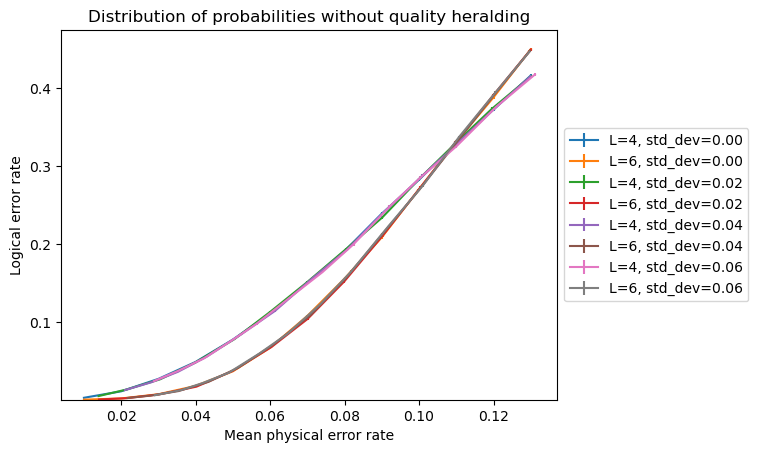

In [220]:
plt.figure()

for std_dev in [0,0.02,0.04,0.06]:
    print("std_dev", std_dev)


    time0 = time.time()
    num_shots = 300
    num_realizations = 200
    Ls = [4,6]
    log_errors_all_L_normal = []

    mean_all_L_normal = []

    for L in Ls:
        print("Simulating L={}...".format(L))
        Hx = toric_code_x_stabilisers(L)
        logX = toric_code_x_logicals(L)
        log_errors = []
        mean_p = []
        for error_probability in ps:
            #print("Error probability",p)
            num_errors = 0
            mean_val = 0
            for error_realization in range(num_realizations):

                qubit_probabilities = norm.rvs(loc = error_probability, scale=std_dev, size=Hx.shape[1])
                #For edge weights we actually need 0.5 as upper cutoff
                qubit_probabilities = np.array([np.max([0.0001,np.min([p,0.4999])]) for p in qubit_probabilities])
                mean, var = norm.stats(loc = error_probability, scale=std_dev, moments='mv') #cutoff will change it away from mean
                mean = np.sum(qubit_probabilities)/Hx.shape[1]

                num_errors += num_decoding_failures_vectorised_ignorant_decoder(Hx, logX, qubit_probabilities, num_shots)
                mean_val += mean

            log_errors.append(num_errors/num_shots/num_realizations)
            #print("mean of means", mean_val/num_realizations)
            mean_p.append(mean_val/num_realizations)

        log_errors_all_L_normal.append(np.array(log_errors))
        mean_all_L_normal.append(np.array(mean_p))

    #print(time.time()-time0)
    

    for L, means, logical_errors in zip(Ls, mean_all_L_normal, log_errors_all_L_normal):
        std_err = (logical_errors*(1-logical_errors)/num_shots/num_realizations)**0.5
        plt.errorbar(means, logical_errors, yerr=std_err, label="L=%d"%L+", std_dev=%.2f"%std_dev)

    
plt.xlabel("Mean physical error rate")
plt.ylabel("Logical error rate")

plt.ylim(bottom=1e-4, top=None)

#plt.xscale('log')
#plt.yscale('log')

plt.title("Distribution of probabilities without quality heralding")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Generating probabilities p for lognormal distribution

To sort out: conventions to have a given mean

Following the documentation at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html we have the convention that the probability density function is
$$f(x,s) = \frac{1}{xs \sqrt{2\pi}}\exp\left(-\frac{\log^2(x)}{2s^2}\right) $$

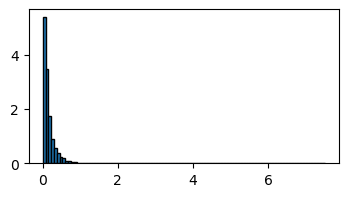

Theoretical mean: 0.16487212707001284 . Mean of data points before cutoff: 0.16295543300427573


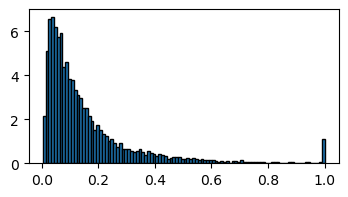

[{'I': 0.5967386847559135, 'X': 0.1344204384146955, 'Y': 0.1344204384146955, 'Z': 0.1344204384146955}, {'I': 0.9736020934504627, 'X': 0.008799302183179114, 'Y': 0.008799302183179114, 'Z': 0.008799302183179114}, {'I': 0.8372966521448586, 'X': 0.05423444928504714, 'Y': 0.05423444928504714, 'Z': 0.05423444928504714}, {'I': 0.7633376295105856, 'X': 0.0788874568298048, 'Y': 0.0788874568298048, 'Z': 0.0788874568298048}, {'I': 0.7942791906279929, 'X': 0.06857360312400239, 'Y': 0.06857360312400239, 'Z': 0.06857360312400239}]
Theoretical mean: 0.16487212707001284 . Mean of data points after cutoff: 0.1570070080412


In [10]:
# Generating probabilities

samplesize = 10000
probabilities = lognorm.rvs(s=1, scale=0.1, size=samplesize)

mean = lognorm.stats(s=1, scale = 0.1, moments='m')

plt.figure(figsize=(4,2))
plt.hist(probabilities, density=True, edgecolor='black', bins=100)
plt.show()

print('Theoretical mean:', mean, '. Mean of data points before cutoff:', np.sum(probabilities)/samplesize)

# We can only accept probabilities that lie between 0 and 1. We therefore need to impose a cutoff.
# (Note: the histogram will look slightly different due to having the same number of bins.)
probabilities = [np.min([p,1]) for p in probabilities]
plt.figure(figsize=(4,2))
plt.hist(probabilities, density=True, edgecolor='black', bins=100)
plt.show()

# We can turn these into uniform probabilities for XYZ type errors, as an example.
fault_probabilities = [{'I' : 1-p, 'X' : p/3, 'Y' : p/3, 'Z' : p/3} for p in probabilities]
# Printing the first five as an example
print(fault_probabilities[0:5])

print('Theoretical mean:', mean, '. Mean of data points after cutoff:', np.sum(probabilities)/samplesize)

### Todo
- Should we remove p>1 draws rather than setting to 1?
- Put tiny variance and recover case of all probabilities same, compare results
- Then increase variance while keeping mean same, compare curves

Mean,var 0.20001000025000418 4.000600046670898e-06


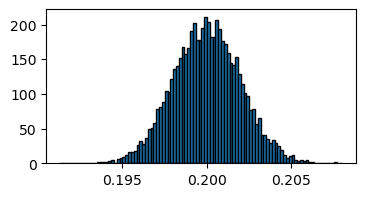

Theoretical mean: 0.20001000025000418 . Mean of data points before cutoff: 0.199996106374773


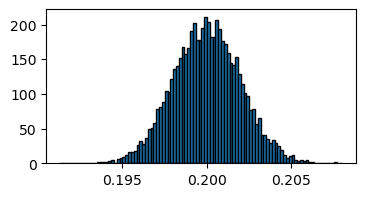

Theoretical mean: 0.20001000025000418 . Mean of data points after cutoff: 0.199996106374773


In [11]:
samplesize = 10000
s = 0.01 #we want small variance
scale = 0.2 #sets where the mean ends up

probabilities = lognorm.rvs(s=s, scale=scale, size=samplesize)

mean,var = lognorm.stats(s=s, scale = scale, moments='mv')
print('Mean,var',mean,var)

plt.figure(figsize=(4,2))
plt.hist(probabilities, density=True, edgecolor='black', bins=100)
plt.show()

print('Theoretical mean:', mean, '. Mean of data points before cutoff:', np.sum(probabilities)/samplesize)

# We can only accept probabilities that lie between 0 and 1. We therefore need to impose a cutoff.
# (Note: the histogram will look slightly different due to having the same number of bins.)
probabilities = [np.min([p,1]) for p in probabilities]
plt.figure(figsize=(4,2))
plt.hist(probabilities, density=True, edgecolor='black', bins=100)
plt.show()

# We now turn these into uniform probabilities for XYZ type errors, as an example.
fault_probabilities = [{'I' : 1-p, 'X' : p/3, 'Y' : p/3, 'Z' : p/3} for p in probabilities]

print('Theoretical mean:', mean, '. Mean of data points after cutoff:', np.sum(probabilities)/samplesize)